# Workshop 2 - Implementation
    
In this notebook you will continue to implement the matrix method and check it with some sanity checks.

> ### Task 0
>
> Check whether your implementation of last week was correct using the provided solution

In [27]:
import numpy as np
import matrixmethod as mm
%config InlineBackend.figure_formats = ['svg']

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. The Node class
The `Node` class from last week is unchanged and complete

## 2. The Element class

The implementation is incomplete:
- The function `add_distributed_load` should compute the equivalent load vector for a constant load $q$ and moves those loads to the nodes belonging to the element. Remember to use the `add_load` function of the `Node` class to store the equivalent loads (remember we have two nodes per element). Also keep local/global transformations in mind and store `self.q = q` for later use;
- The function `bending_moments` receives the nodal displacements of the element in the global coordinate system (`u_global`) and uses it to compute the value of the bending moment at `num_points` equally-spaced points along the element length. Keep local/global transformations in mind and use the ODE approach in SymPy / Maple / pen and paper to compute an expression for $M$. Do the same for for $w$ in the function `full_displacement`.

> ### Task 2.1
>
> Add the missing pieces to the code, before you perform the checks below.

> ### Task 2.2
>
> Having made your implementations, it is now time to verify the first addition of your code with a simple sanity check. We would like to solve the following simply-supported beam:
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/ssbeam.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Use the code blocks below to set up this problem. After you've added the load, print the element using `print(YOUR ELEMENT)`. Do the shown values for the nodal loads correspond with what you'd expect?

In [28]:
mm.Node.clear()
mm.Element.clear()

In [29]:
# Define General Properties
l = 1
q = 10 
EA = 1

# Define Nodes
node1 = mm.Node(0,0)
node2 = mm.Node(l,0)

# Define element and section properties
elem = mm.Element(node1, node2)

section={}
section['EA'] = 1
section['EI'] = 1

elem.set_section(section)

# Assign load
elem.add_distributed_load([0,q])

# Assign Constraints
con = mm.Constrainer()

con.fix_dof(node1,0,0)
con.fix_dof(node1,1,0)

con.fix_dof(node2,1,0)


In [30]:
print(elem)

Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[ 0.          5.         -0.83333333]
with node #2:
 This node has:
 - x coordinate=1,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[0.         5.         0.83333333]


> ### Task 2.3
>  Now solve the nodal displacements. Once you are done, compare the rotation at the right end of the beam. Does it match the solution you already know?

In [31]:
#Assemble Global Matrix (just one element)
k_global = elem.stiffness()

#Assemble Load Vector
f_global = np.zeros(6)
f_global[0:3] = node1.p
f_global[3:6] = node2.p

#Solve Displacements
Kff, Fff = con.constrain(k_global,f_global)
u = np.matmul(np.linalg.inv(Kff), Fff)
print(u)
con.full_disp(u)


[-0.41666667  0.          0.41666667]


array([ 0.        ,  0.        , -0.41666667,  0.        ,  0.        ,
        0.41666667])

GMylo: In the cell above $u$ includes $\phi_1, u_2, \phi_2$, since the other degrees of freedom are constrained

> ### Task 2.4
> Calculate the bending moment at midspan and plot the moment distribution using `plot_moment_diagram`. Do the values and shape match with what you'd expect?

In [32]:
u_elem = con.full_disp(u)


> ### Task 2.5
> Calculate the deflection at midspan and plot the deflected structure using `plot_displaced`. Do the values and shape match with what you'd expect?

(array([0., 0., 0.]), array([0.        , 0.13020833, 0.        ]))


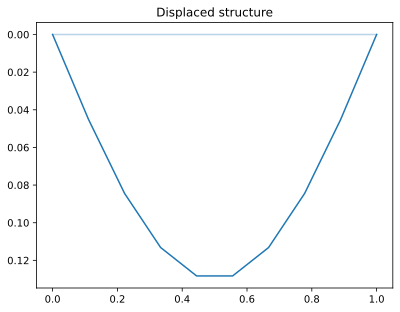

In [33]:
print(elem.full_displacement(u_elem, num_points=3))
elem.plot_displaced(u_elem)

In [34]:
# Experiment
# elem.plot_numbered_structure(1)

## 3. The Constrainer class

We're going to expand our Constrainer class, but the implementation is incomplete:
- The constrainer class should be able to handle non-zero boundary conditions too. `constrain` should be adapted to do so + the docstring of the class itself. Furthermore, the assert statement of `fix_dof` should be removed.
- The function `support_reactions` is incomplete. Since the constrainer is always first going to get `constrain` called, here we already have access to `self.free_dofs`. Together with `self.cons_dofs`, you should have all you need to compute reactions. Note that `f` is also passed as argument. Make sure you take into account the contribution of equivalent element loads that go directly into the supports without deforming the structure.

> ### Task 3.1
>
> Add the missing pieces to the code and docstring, before you perform the checks below.

> ### Task 3.2
>
> We're going to verify our implementation. Therefore, we're going to solve an extension bar, supported at both ends, with a load $q$.
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/sanitycheck_3.2.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Can you say on beforehand what will be the displacements? And what will be the support reactions?
> Use the code blocks below to set up and solve this problem and check the required quantities to make sure your implementation is correct.

In [35]:
mm.Node.clear()
mm.Element.clear()

In [36]:
# Define General Properties
l = 1
q = 10 
EA = 1
EI = 1

# Define Nodes
node1 = mm.Node(0,0)
node2 = mm.Node(l,0)

# Define element and section properties
elem = mm.Element(node1, node2)

section={}
section['EA'] = EA
section['EI'] = EI

elem.set_section(section)

# Assign load
elem.add_distributed_load([q,0])

# Assign Constraints
con = mm.Constrainer()

con.fix_dof(node1,0,0)
con.fix_dof(node1,1,0)

con.fix_dof(node2,0,0)
con.fix_dof(node2,1,0)


In [37]:
#Assemble Global Matrix (just one element)
k_global = elem.stiffness()

#Assemble Load Vector
f_global = np.zeros(6)
f_global[0:3] = node1.p
f_global[3:6] = node2.p

#Solve Displacements
Kff, Fff = con.constrain(k_global,f_global)
u_free = np.matmul(np.linalg.inv(Kff), Fff)
print(u_free)
u_elem = con.full_disp(u_free)
print(u_elem)

print(elem.full_displacement(u_elem, num_points=3))

[0. 0.]
[0. 0. 0. 0. 0. 0.]
(array([ 0.  , -1.25,  0.  ]), array([0., 0., 0.]))


In [38]:
sup_reactions = con.support_reactions(k_global,u_free, f_global)
print(sup_reactions)

[-5.  0. -5.  0.]


> ### Task 3.3
>
> Again, we're going to verify our implementation. Therefore, we're going solve a beam, with a load $F$ and support displacement $\bar w$ for the right support.
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/sanitycheck_3.3_new.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Use the code blocks below to set up and solve this problem and check the required quantities to make sure your implementation is correct.

In [49]:
mm.Node.clear()
mm.Element.clear()

In [50]:
# Define General Properties
l = 1
F = 10
w_l_imposed = 1
EA = 1
EI = 1

# Define Nodes
node1 = mm.Node(0,0)
node2 = mm.Node(l,0)

# Define element and section properties
elem = mm.Element(node1, node2)

section={}
section['EA'] = EA
section['EI'] = EI

elem.set_section(section)

# Assign load
node2.add_load([0,F,0])

# Assign Constraints
con = mm.Constrainer()

con.fix_dof(node1,0,0)
con.fix_dof(node1,1,0)
con.fix_dof(node1,2,0)

con.fix_dof(node2,1,w_l_imposed)


In [51]:
#Assemble Global Matrix (just one element)
k_global = elem.stiffness()

#Assemble Load Vector
f_global = np.zeros(6)
f_global[0:3] = node1.p
f_global[3:6] = node2.p

#Solve Displacements
Kff, Fff = con.constrain(k_global,f_global)
u_free = np.matmul(np.linalg.inv(Kff), Fff)
print(u_free)
u_elem = con.full_disp(u_free)
print(u_elem)

print(elem.full_displacement(u_elem, num_points=3))

[ 0.  -1.5]
[ 0.   0.   0.   0.   1.  -1.5]
(array([0., 0., 0.]), array([0.    , 0.3125, 1.    ]))


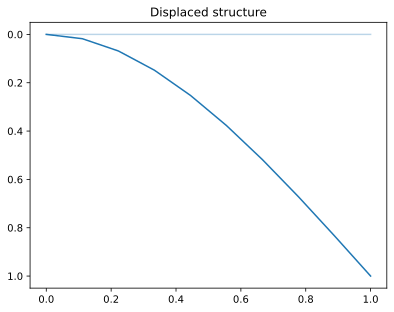

In [52]:
elem.plot_displaced(u_elem)

In [53]:
sup_reactions = con.support_reactions(k_global,u_free, f_global)
print(sup_reactions)

[ 0. -3.  3. -7.]
